In [1]:
# Importing libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout

import matplotlib.pyplot as plt

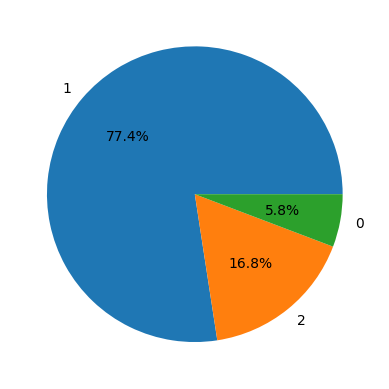

In [2]:
# Load dataset
import pandas as pd

df = pd.read_csv('Dataset---Hate-Speech-Detection-using-Deep-Learning.csv')
plt.pie(df['class'].value_counts().values,
		labels = df['class'].value_counts().index,
		autopct='%1.1f%%')
plt.show()

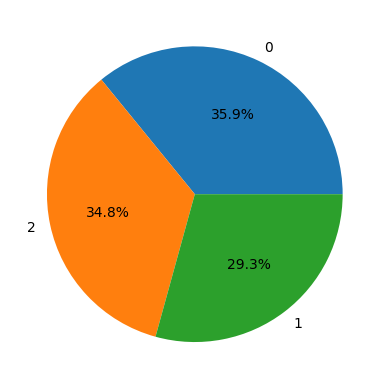

In [3]:
# balance the dataset

class_2 = df[df['class'] == 2]
class_1 = df[df['class'] == 1].sample(n=3500)
class_0 = df[df['class'] == 0]

balanced_df = pd.concat([class_0, class_0, class_0, class_1, class_2], axis=0)
plt.pie(balanced_df['class'].value_counts().values,
		labels = balanced_df['class'].value_counts().index,
		autopct='%1.1f%%')
plt.show()

In [4]:
# data cleaning
import string
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# Remove twitter terms and urls
def remove_twitter_terms(text):
	for word in text.split():
		if '@' in word:
			text = text.replace(word, '')
	text = text.replace('rt', '')
	text = re.sub(r'http\S+', '', text)
	return text

# Remove punctuations 
punctuations_list = string.punctuation
def remove_punctuations(text):
	temp = str.maketrans('', '', punctuations_list)
	return text.translate(temp)

# Remove stopwords
def remove_stopwords(text):
	stop_words = stopwords.words('english')
	imp_words = []
	# Storing the important words
	for word in str(text).split():
		if word not in stop_words:
			# Let's Lemmatize the word as well
			# before appending to the imp_words list.
			lemmatizer = WordNetLemmatizer()
			lemmatizer.lemmatize(word)
			imp_words.append(word)
	output = " ".join(imp_words)
	return output

In [5]:
# Lower case all the words of the tweet before any preprocessing

balanced_df['tweet'] = balanced_df['tweet'].str.lower()
balanced_df['tweet'] = balanced_df['tweet'].apply(lambda x: remove_twitter_terms(x))
balanced_df['tweet']= balanced_df['tweet'].apply(lambda x: remove_punctuations(x))
balanced_df['tweet'] = balanced_df['tweet'].apply(lambda x: remove_stopwords(x))

balanced_df.head()

,class,tweet
85,0,queer gaywad
89,0,alsarabsss hes beaner smh tell hes mexican
110,0,youre fucking gay blacklisted hoe holding tehg...
184,0,lmfaoooo hate black people theres black people...
202,0,least im nigger lmfao


In [6]:
# split data

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

features = balanced_df['tweet']
target = balanced_df['class']

X_train_pd, X_test_pd, Y_train_pd, Y_test_pd = train_test_split(features,
												target,
												test_size=0.2,
												random_state=23)

# Convert labels to categorical
Y_train = to_categorical(Y_train_pd, num_classes=3)
Y_test = to_categorical(Y_test_pd, num_classes=3)



In [7]:
# Tokenization

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len = 100

token = Tokenizer(num_words=max_words,
				lower=True,
				split=' ')

token.fit_on_texts(X_train_pd)

# training the tokenizer
token = Tokenizer(num_words=max_words,
				lower=True,
				split=' ')
token.fit_on_texts(X_train_pd)

#Generating token embeddings
X_train = token.texts_to_sequences(X_train_pd)
X_train = pad_sequences(X_train,
						maxlen=50,
						padding='post',
						truncating='post')

X_test = token.texts_to_sequences(X_test_pd)
X_test = pad_sequences(X_test,
						maxlen=50,
						padding='post',
						truncating='post')

In [8]:
# Building the CNN Model
model = Sequential(
    [
        Embedding(max_words, 32, input_length=max_words),
        Conv1D(32, 3, padding='same', activation='relu'),
        MaxPooling1D(),
        Flatten(),
        Dense(250, activation='relu'),
        Dense(3, activation='softmax')
    ]
)      # initilaizing the Sequential nature for CNN model


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

C:\Users\Emma\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(patience=3,
				monitor = 'val_accuracy',
				restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
					monitor = 'val_loss',
					factor = 0.5,
					verbose = 0)



In [10]:
# Fitting the data onto model
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test),
                    epochs=50, batch_size=128, verbose=2,
                    callbacks=[es, lr]
                    )

# Getting score metrics from our model
scores = model.evaluate(X_test, Y_test, verbose=0)
# Displays the accuracy of correct sentiment prediction over test data
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/50
75/75 - 2s - 30ms/step - accuracy: 0.5587 - loss: 0.9259 - val_accuracy: 0.8038 - val_loss: 0.5185 - learning_rate: 0.0010
Epoch 2/50
75/75 - 0s - 6ms/step - accuracy: 0.8724 - loss: 0.3512 - val_accuracy: 0.8645 - val_loss: 0.3813 - learning_rate: 0.0010
Epoch 3/50
75/75 - 0s - 6ms/step - accuracy: 0.9361 - loss: 0.1912 - val_accuracy: 0.8829 - val_loss: 0.3449 - learning_rate: 0.0010
Epoch 4/50
75/75 - 0s - 6ms/step - accuracy: 0.9656 - loss: 0.1131 - val_accuracy: 0.8959 - val_loss: 0.3436 - learning_rate: 0.0010
Epoch 5/50
75/75 - 0s - 6ms/step - accuracy: 0.9804 - loss: 0.0738 - val_accuracy: 0.8996 - val_loss: 0.3651 - learning_rate: 0.0010
Epoch 6/50
75/75 - 0s - 6ms/step - accuracy: 0.9850 - loss: 0.0539 - val_accuracy: 0.9080 - val_loss: 0.3561 - learning_rate: 0.0010
Epoch 7/50
75/75 - 0s - 6ms/step - accuracy: 0.9904 - loss: 0.0361 - val_accuracy: 0.9109 - val_loss: 0.3574 - learning_rate: 5.0000e-04
Epoch 8/50
75/75 - 0s - 6ms/step - accuracy: 0.9916 - loss: 0.03

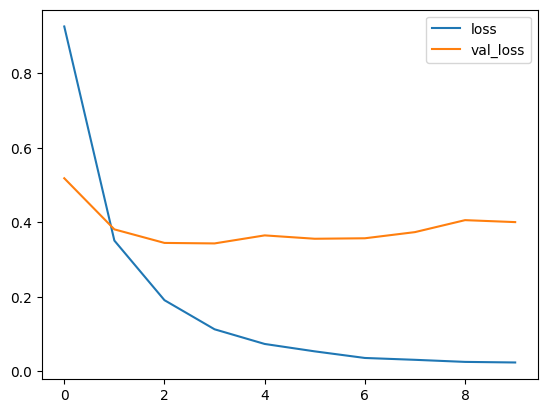

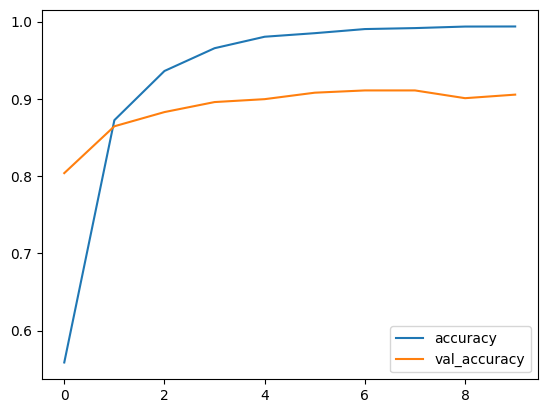

In [11]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.show()

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


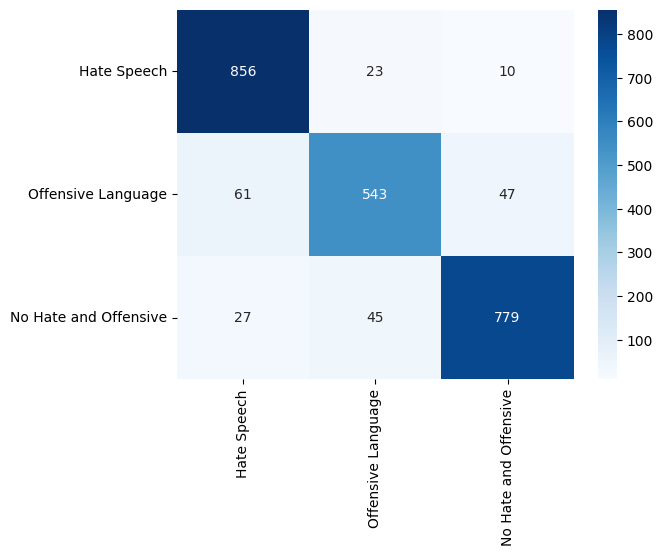

In [12]:
# see the prediction

import numpy as np
pred = model.predict(X_test)
pred_class = np.argmax(pred, axis=1)

# plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(Y_test_pd, pred_class)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Hate Speech', 'Offensive Language', 'No Hate and Offensive'], yticklabels=['Hate Speech', 'Offensive Language', 'No Hate and Offensive'])
plt.show()


In [13]:
# create a dataframe
pred_df = pd.DataFrame(pred_class, columns=['pred_class'])
pred_df['actual_class'] = Y_test_pd.values
pred_df['tweet'] = X_test_pd.values


pred_df.head()


,pred_class,actual_class,tweet
0,1,1,bow wow look like stress saving hoe wearing
1,0,0,ayo even kill handicapped crippled bitcheslook...
2,0,0,roses red orchids bigger donts tell yo daddy f...
3,0,0,ur faggot change name bday get bday tweets ain...
4,2,2,js feet song trash loll


In [14]:
# look at the misclassified tweets

misclassified_tweets = pred_df[pred_df['pred_class'] != pred_df['actual_class']]

misclassified_tweets.head()


,pred_class,actual_class,tweet
12,0,1,dont pity hate faggots sexual mutations necess...
26,2,0,wanna say something soooooo bad two cunts twit...
31,2,1,ead especially rita died dexter trash breaking...
49,0,1,bunch rednecks hammered three straight days
74,1,2,head big snapbacks128553128532 128557128557128...


In [16]:
# Save the model
model.save('cnn_simple.keras')

In [18]:
# To load the model later:
from tensorflow.keras.models import load_model
loaded_model = load_model('cnn_simple.keras')

# Verify the loaded model works the same
test_pred = loaded_model.predict(X_test)
test_pred_class = np.argmax(test_pred, axis=1)

# Confirm predictions match
print("Predictions match:", np.array_equal(pred_class, test_pred_class))


28/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

C:\Users\Emma\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 9 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Predictions match: True
